# NASA - MODEL

## Setup 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys, os, yaml

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

sns.set_style("darkgrid")

DATASET = "NASA"
COLAB = 'google.colab' in sys.modules

from IPython.display import display, Markdown
from pprint import pprint 

SEED = 666
DEBUG = True

In [2]:
COLAB = 'google.colab' in sys.modules

if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
  if not os.path.isdir(ROOT): os.makedirs(ROOT)
else:
  ROOT = "./"

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Load Dataset

In [3]:
df = pd.read_pickle(f"{ROOT}/data/data.pkl")
print(df.shape)
df.head()

(1290, 37)


,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defects
0,1.0,4.0,7.0,24.0,0.0,1.0,0.13,0.0,0.0,1.0,1.0,6.0,1.0,0.0,1.0,0.0,17.88,7.43,986.77,0.04,34.0,0.13,54.82,132.83,1.0,0.0,0.0,7.0,0.03,13.0,21.0,7.0,8.0,34.0,96.88,8.0,False
1,1.0,1.0,11.0,3.0,0.0,1.0,0.08,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,42.62,7.81,2598.31,0.11,77.0,0.13,144.35,332.79,1.0,0.0,0.0,3.0,0.06,29.0,48.0,13.0,7.0,17.0,93.33,12.0,False
2,1.0,1.0,0.0,0.0,0.0,1.0,1.00,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,33.44,0.63,13.06,0.01,9.0,1.60,0.73,20.90,1.0,0.0,0.0,3.0,0.33,5.0,4.0,4.0,1.0,3.0,0.00,1.0,False
3,1.0,0.0,1.0,0.0,0.0,1.0,0.50,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,10.87,3.50,133.19,0.01,11.0,0.29,7.40,38.05,1.0,0.0,0.0,2.0,0.33,4.0,7.0,4.0,7.0,3.0,50.00,2.0,False
4,3.0,1.0,1.0,0.0,6.0,2.0,1.00,2.0,3.0,1.0,0.5,5.0,1.0,0.0,1.0,1.0,11.07,4.38,211.89,0.02,14.0,0.23,11.77,48.43,0.5,2.0,3.0,5.0,0.50,5.0,9.0,4.0,7.0,4.0,50.00,2.0,False


# Model

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BRANCH_COUNT                     1290 non-null   float64
 1   CALL_PAIRS                       1290 non-null   float64
 2   LOC_CODE_AND_COMMENT             1290 non-null   float64
 3   LOC_COMMENTS                     1290 non-null   float64
 4   CONDITION_COUNT                  1290 non-null   float64
 5   CYCLOMATIC_COMPLEXITY            1290 non-null   float64
 6   CYCLOMATIC_DENSITY               1290 non-null   float64
 7   DECISION_COUNT                   1290 non-null   float64
 8   DECISION_DENSITY                 1290 non-null   float64
 9   DESIGN_COMPLEXITY                1290 non-null   float64
 10  DESIGN_DENSITY                   1290 non-null   float64
 11  EDGE_COUNT                       1290 non-null   float64
 12  ESSENTIAL_COMPLEXITY

In [5]:
target = 'defects'
df[target].value_counts(normalize=True)

False    0.983721
True     0.016279
Name: defects, dtype: float64

Dealing with `imbalanced` dataset

In [6]:
features = [c for c in df.columns if c != target]
print(f"Number of features {len(features)}\n{features}")

Number of features 36
['BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'CYCLOMATIC_DENSITY', 'DECISION_COUNT', 'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MAINTENANCE_SEVERITY', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES', 'PERCENT_COMMENTS', 'LOC_TOTAL']


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings

scaler = StandardScaler()

In [8]:
df_tmp = df.drop(target,axis=1)
X = scaler.fit_transform(df.loc[:,features].values)
y = df[target].values
X.shape, y.shape

((1290, 36), (1290,))

SMOTE to generate synthetic samples for the minority class.

In [9]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(X_res.shape, y_res.shape)
print(f"y - True values -> {y.sum()/y.shape[0]*100:.2f}%,\ny_res - True values -> {sum(y_res)/y_res.shape[0]*100}%")

(2538, 36) (2538,)
y - True values -> 1.63%,
y_res - True values -> 50.0%


In [10]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVC" : SVC(probability=True),
    "RF": RandomForestClassifier(),
}

def pr_auc(model, X, y):
    model.fit(X, y)
    y_prob = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_prob)
    pr_auc_r = auc(recall, precision)
    # Plot the precision-recall curve
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc_r:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()
    return auc(recall, precision)
    
def train_models(x_pr,y_pr,x_cv,y_cv):
    warnings.filterwarnings("ignore")

    best_pr = {'name_pr': None, 'pr_auc': 0 }
    best_cv = {'name_cv' : None, 'mean': 0 }
    for name,model in models.items():
        
        pr_auc_score = pr_auc(model,x_pr,y_pr)
        
        scores = cross_val_score(model, x_cv, y_cv, scoring='accuracy', cv=10)
        mean = scores.mean()
        std = scores.std()
        
        print ("\nModel %s" % name)
        print(f"\tPR AUC: {pr_auc_score:.3f}")
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")
        
        if pr_auc_score>best_pr['pr_auc']:
            best_pr = {'name_pr':name, 'pr_auc':pr_auc_score}
            
        if mean>best_cv['mean']:
            best_cv = {'name_cv':name, 'mean':mean}
            
    print (f"\nBest Performing Model {best_pr['name_pr']} with PR AUC = {best_pr['pr_auc']:.2%}" )
    print (f"\nBest Performing Model {best_cv['name_cv']} with (mean CV of) accuracy = {best_cv['mean']:.2%}" )
    return best_pr['name_pr'],best_cv['name_cv']

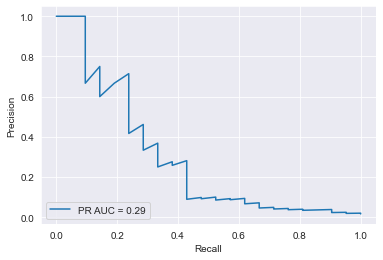


Model LR
	PR AUC: 0.287
	CV scores: 0.87, 0.87, 0.87, 0.86, 0.78, 0.85, 0.80, 0.86, 0.80, 0.79
	mean=83.53% std=0.0355


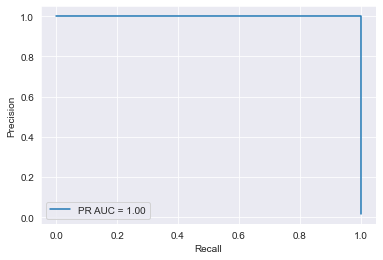


Model DT
	PR AUC: 1.000
	CV scores: 0.94, 0.99, 0.98, 0.96, 0.96, 0.97, 0.97, 0.96, 0.97, 0.98
	mean=96.97% std=0.0135


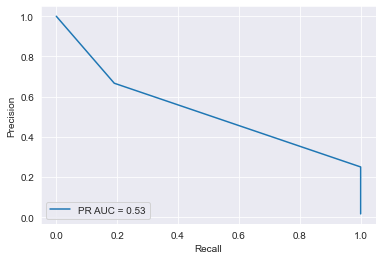


Model KNN
	PR AUC: 0.530
	CV scores: 0.96, 0.97, 0.97, 0.96, 0.92, 0.97, 0.94, 0.92, 0.94, 0.93
	mean=94.80% std=0.0209


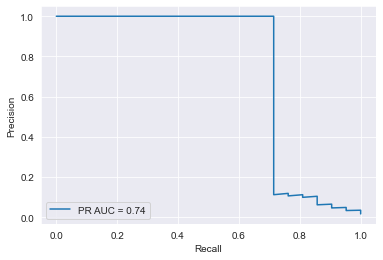


Model SVC
	PR AUC: 0.737
	CV scores: 0.92, 0.88, 0.85, 0.88, 0.83, 0.89, 0.85, 0.89, 0.85, 0.84
	mean=86.92% std=0.0255


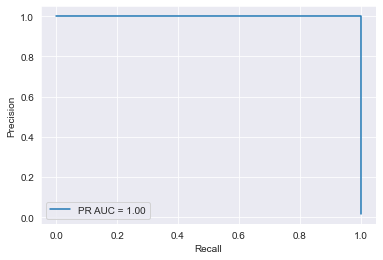


Model RF
	PR AUC: 1.000
	CV scores: 0.95, 1.00, 1.00, 1.00, 0.99, 0.99, 0.99, 0.99, 0.97, 0.99
	mean=98.66% std=0.0131

Best Performing Model DT with PR AUC = 100.00%

Best Performing Model RF with (mean CV of) accuracy = 98.66%


In [11]:
best_model_cross_val, best_model_pr_auc = train_models(X,y,X_res,y_res)

In [12]:
print("Number of features starting:", len(features))

Number of features starting: 36


Optimal number of features : 31


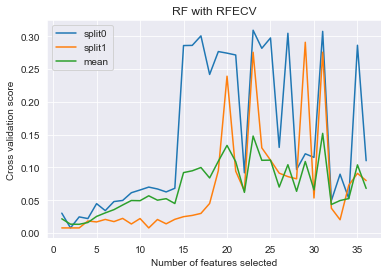

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = best_model_pr_auc
model = models[name]

def pr_auc_scorer(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

rfecv = RFECV(estimator=model, step=1, cv=5, scoring=make_scorer(pr_auc_scorer, needs_proba=True),n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [14]:
len(rfecv.support_), len(features)

(36, 36)

In [15]:
# list of features selected
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected_pr = np.array(features)[rfecv.support_].tolist()
print(len(features_selected_pr))
features_selected_pr

31


['CALL_PAIRS',
 'LOC_CODE_AND_COMMENT',
 'LOC_COMMENTS',
 'CONDITION_COUNT',
 'CYCLOMATIC_COMPLEXITY',
 'CYCLOMATIC_DENSITY',
 'DECISION_DENSITY',
 'DESIGN_COMPLEXITY',
 'DESIGN_DENSITY',
 'EDGE_COUNT',
 'LOC_EXECUTABLE',
 'PARAMETER_COUNT',
 'HALSTEAD_CONTENT',
 'HALSTEAD_DIFFICULTY',
 'HALSTEAD_EFFORT',
 'HALSTEAD_ERROR_EST',
 'HALSTEAD_LENGTH',
 'HALSTEAD_LEVEL',
 'HALSTEAD_PROG_TIME',
 'HALSTEAD_VOLUME',
 'MAINTENANCE_SEVERITY',
 'MULTIPLE_CONDITION_COUNT',
 'NODE_COUNT',
 'NORMALIZED_CYLOMATIC_COMPLEXITY',
 'NUM_OPERANDS',
 'NUM_OPERATORS',
 'NUM_UNIQUE_OPERANDS',
 'NUM_UNIQUE_OPERATORS',
 'NUMBER_OF_LINES',
 'PERCENT_COMMENTS',
 'LOC_TOTAL']

Optimal number of features : 30


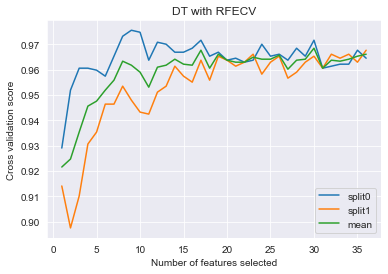

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = best_model_cross_val
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="accuracy",n_jobs=-1)
rfecv.fit(X_res, y_res)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [17]:
len(rfecv.support_), len(features)

(36, 36)

In [18]:
# list of features selected
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected_cv = np.array(features)[rfecv.support_].tolist()
print(len(features_selected_cv))
features_selected_cv

30


['CALL_PAIRS',
 'LOC_CODE_AND_COMMENT',
 'LOC_COMMENTS',
 'CYCLOMATIC_COMPLEXITY',
 'CYCLOMATIC_DENSITY',
 'DECISION_COUNT',
 'DECISION_DENSITY',
 'DESIGN_COMPLEXITY',
 'DESIGN_DENSITY',
 'EDGE_COUNT',
 'ESSENTIAL_COMPLEXITY',
 'ESSENTIAL_DENSITY',
 'LOC_EXECUTABLE',
 'PARAMETER_COUNT',
 'HALSTEAD_CONTENT',
 'HALSTEAD_DIFFICULTY',
 'HALSTEAD_EFFORT',
 'HALSTEAD_LEVEL',
 'HALSTEAD_PROG_TIME',
 'MAINTENANCE_SEVERITY',
 'MODIFIED_CONDITION_COUNT',
 'MULTIPLE_CONDITION_COUNT',
 'NODE_COUNT',
 'NORMALIZED_CYLOMATIC_COMPLEXITY',
 'NUM_OPERANDS',
 'NUM_OPERATORS',
 'NUM_UNIQUE_OPERANDS',
 'NUM_UNIQUE_OPERATORS',
 'NUMBER_OF_LINES',
 'PERCENT_COMMENTS']

In [19]:
# normalise 
X_pr = scaler.fit_transform(df.loc[:,features_selected_pr].values)
y_pr = df[target].values
X_cv = scaler.fit_transform(df.loc[:,features_selected_cv].values)
X_cv, y_cv = sm.fit_resample(X_pr, y_pr)

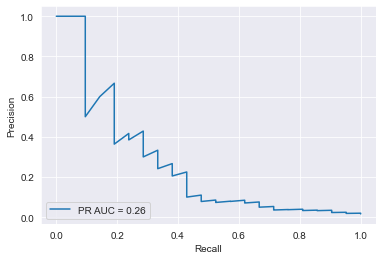


Model LR
	PR AUC: 0.258
	CV scores: 0.89, 0.84, 0.87, 0.83, 0.77, 0.84, 0.80, 0.85, 0.80, 0.80
	mean=82.86% std=0.0349


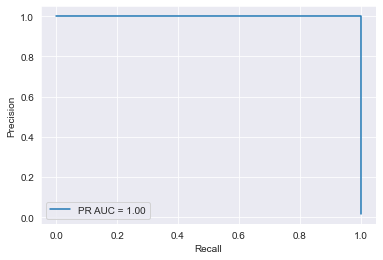


Model DT
	PR AUC: 1.000
	CV scores: 0.94, 0.98, 0.98, 0.97, 0.96, 0.98, 0.96, 0.97, 0.98, 0.97
	mean=97.12% std=0.0126


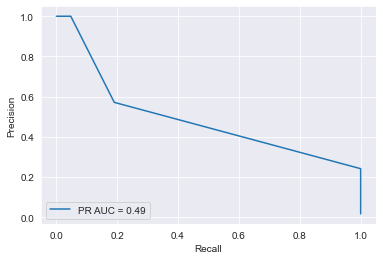


Model KNN
	PR AUC: 0.489
	CV scores: 0.96, 0.97, 0.97, 0.96, 0.91, 0.96, 0.94, 0.92, 0.94, 0.93
	mean=94.64% std=0.0207


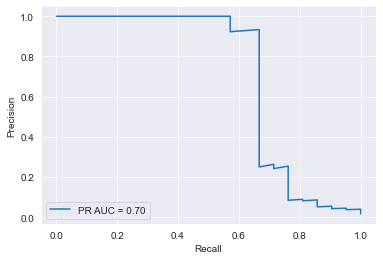


Model SVC
	PR AUC: 0.698
	CV scores: 0.90, 0.89, 0.87, 0.88, 0.84, 0.90, 0.85, 0.88, 0.85, 0.83
	mean=87.00% std=0.0236


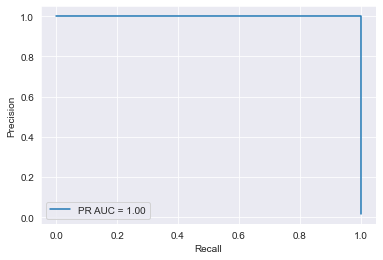


Model RF
	PR AUC: 1.000
	CV scores: 0.96, 1.00, 1.00, 0.99, 0.99, 0.98, 0.99, 0.99, 0.98, 0.98
	mean=98.86% std=0.0097

Best Performing Model DT with PR AUC = 100.00%

Best Performing Model RF with (mean CV of) accuracy = 98.86%


('DT', 'RF')

In [20]:
train_models(X_pr,y_pr,X_cv,y_cv)